In [4]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib


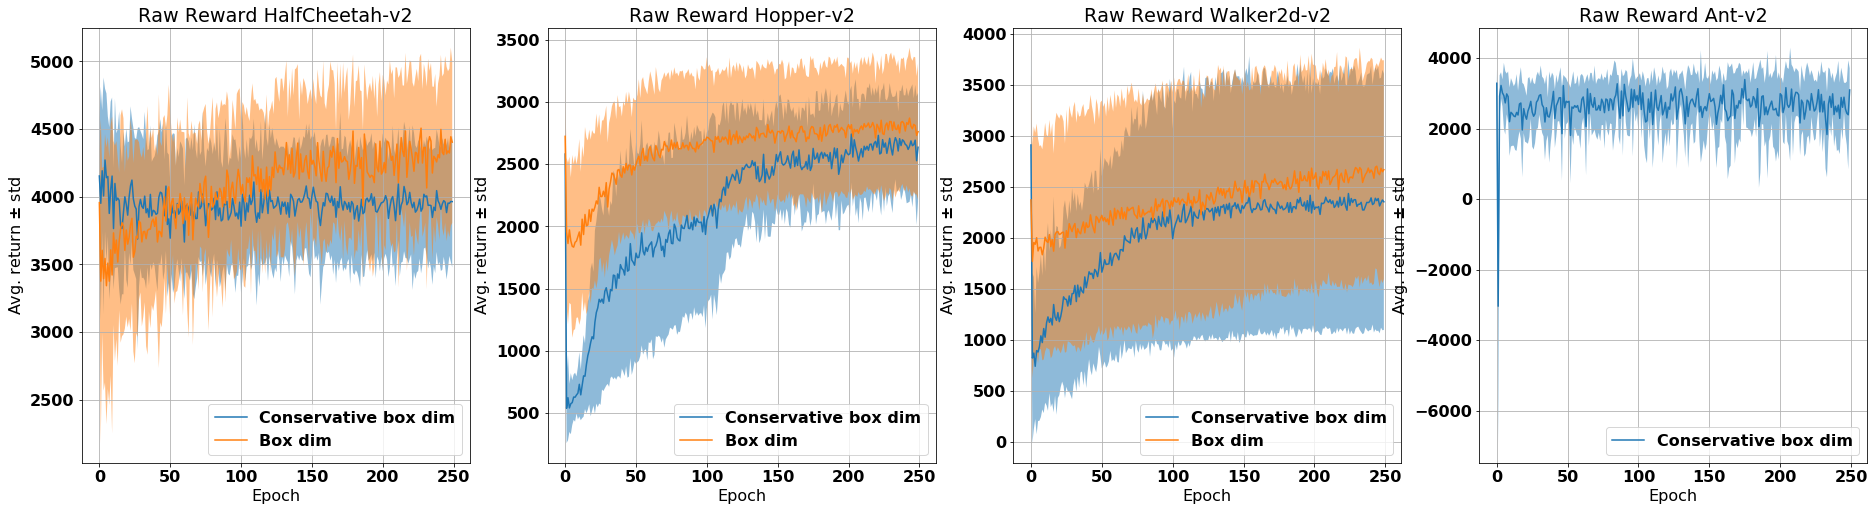

In [5]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2", "Ant-v2"]
init_names = ["identity", "madodiv", "identity", "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()

running build_ext


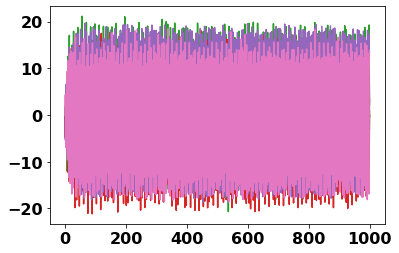

In [6]:
env_name = "HalfCheetah-v2"
env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

obs, acts, rews, _  = do_rollout(env, policy_dict['identity'][7])
plt.plot(obs);

In [123]:

#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,3,4,5,6]
# rollout_length = 1000
# lookback_length = 50

#===============================
env_name = "HalfCheetah-v2"
post_names = ['identity', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:8]))
    qvel = point[8:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

seeds = [0,1,2,3,4,5,6,7,8,9]
rollout_length = 100
lookback_length = 5

#===============================
# env_name = "Hopper-v2"
# post_names = ['madodiv', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:5]))
#     qvel = point[5:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,2,3,4,5,6,7,8,9]
# rollout_length = 3
# lookback_length = 1
# ===============================

def do_rollout_from_state(env, policy, init_state, obs_std=.1, act_std=.1, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        

        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

In [126]:
def do_limit_rollout(trial_num):
    env.seed(trial_num)
    obs, acts, rews, _ = do_rollout_from_state(env, iden_policy, iden_lstate, obs_std, act_std)
    iden_obs = (obs - iden_policy.state_means)/(iden_policy.state_std)
    
    env.seed(trial_num)
    obs, acts, rews, _ = do_rollout_from_state(env, mdim_policy, mdim_lstate, obs_std, act_std)
    mdim_obs = (obs - mdim_policy.state_means)/(mdim_policy.state_std)
    
    return iden_obs, mdim_obs



seed = 2; delta = 1; obs_std=0; act_std=.01
iden_mesh = BoxMesh(delta); iden_l = []
mdim_mesh = BoxMesh(delta); mdim_l = []

iden_policy = policy_dict['identity'][seed]
mdim_policy = policy_dict['mdim_div'][seed]

batch_size = 128


obs, acts, rews, _ = do_rollout(env,iden_policy)
iden_lstate  = obs[500]

obs, acts, rews, _ = do_rollout(env,mdim_policy)
mdim_lstate  = obs[500]


In [129]:
from torch.multiprocessing import Pool
with Pool(10) as pool:

    for i in range(32, 100):
        for j, res in enumerate(pool.imap(do_limit_rollout, range(i*batch_size, i*batch_size+batch_size))):
            iden_obs, mdim_obs = res
           
            for o in iden_obs:
                if o in iden_mesh:
                    iden_mesh[o]+=1
                else:
                    iden_mesh[o]=1

            for o in mdim_obs:
                if o in mdim_mesh:
                    mdim_mesh[o]+=1
                else:
                    mdim_mesh[o]=1
                    
        iden_l.append(len(iden_mesh)); mdim_l.append(len(mdim_mesh))
        print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")

i; 32, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 33, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 34, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 35, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 36, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 37, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 38, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 39, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 40, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 41, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 42, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 43, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 44, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 45, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 46, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 47, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 48, iden: 8918, mdim: 87, ratio: 0.009755550571877103
i; 49, iden: 8918, mdim: 87, ra

Process ForkPoolWorker-163:
Process ForkPoolWorker-162:
Process ForkPoolWorker-166:
Process ForkPoolWorker-164:
Process ForkPoolWorker-165:
Process ForkPoolWorker-168:
Process ForkPoolWorker-169:
Process ForkPoolWorker-167:
Process ForkPoolWorker-160:
Process ForkPoolWorker-161:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sgillen/miniconda3/envs/baselines/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sgillen/miniconda3/envs/baselines/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sgillen/miniconda3/envs/baselines/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sgillen/miniconda3/envs/baselines/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sgillen/miniconda3/envs/baselines/lib/python3.6/multiproce

KeyboardInterrupt: 

Text(0, 0.5, 'mesh points')

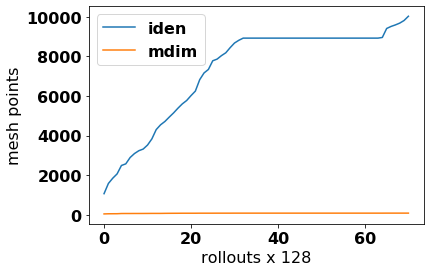

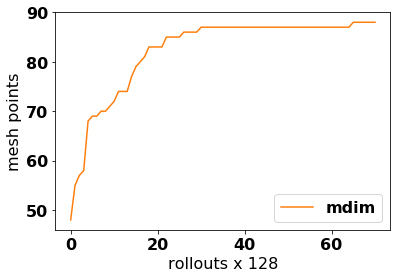

In [132]:
plt.plot(iden_l)
plt.plot(mdim_l)
plt.legend(['iden','mdim'])
plt.xlabel('rollouts x 128')
plt.ylabel('mesh points')

plt.figure()
plt.plot(mdim_l, color='tab:orange')
plt.legend(['mdim'])
plt.xlabel('rollouts x 128')
plt.ylabel('mesh points')

[   23.62844573 19012.68817938]


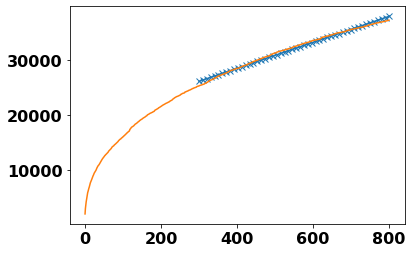

In [42]:
lin_begin = 300
xdata = np.array(range(lin_begin,len(mdim_l)))
ydata = np.array(mdim_l[lin_begin:])

# Fit a curve to the log log line
def f(x, m, b):
    return m * x + b

popt, pcov = opt.curve_fit(f, xdata, ydata)

x = np.linspace(lin_begin,len(mdim_l))
y = popt[0]*x + popt[1]

plt.plot(x,y, 'x-')
plt.plot(mdim_l)

print(popt)

In [80]:
vals = []
keys = []
for key in mdim_mesh.keys():
    vals.append(mdim_mesh[key])
    keys.append(key)
    
vals = np.array(vals)
keys = np.array(keys)
sort_idx = vals.argsort()

vals = vals[sort_idx]
keys = keys[sort_idx]

Text(0, 0.5, '# of states in box')

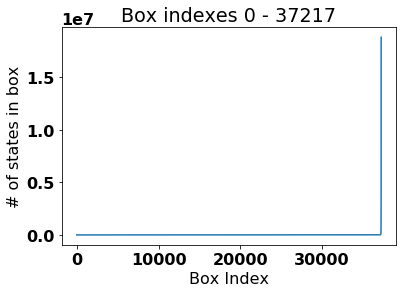

In [113]:
start = 0; stop=1
plt.plot(range(start, len(vals) - stop), vals[start:-stop])

plt.title(f'Box indexes {start} - {len(vals-stop)}')
plt.xlabel('Box Index')
plt.ylabel('# of states in box')

In [100]:
(vals > 4).sum()

14261